# Introduction

**Problem Definition**: We address the problem of automatic polyp detection in colonoscopy images using the Kvasir-SEG dataset. Early detection of polyps is critical for preventing colorectal cancer, but polyps are often easily missed due to their visual similarity to the colon wall (camouflaging).

**Objectives:**

1. Implement a robust Baseline Model using Faster R-CNN with a standard ResNet-50 backbone.

2. Develop an Advanced Model improving on specific challenges:
- Geometric Adaptation: Using K-Means clustering to generate custom anchor boxes for tiny/irregular polyps.
- Visual Enhancement: Using CLAHE to improve contrast.

3. Compare performance using mAP and qualitative analysis.

# Data Loading

**Setup and Imports:**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

!pip install torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

# data augmentation
!pip install albumentations
import albumentations as A

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

In [ ]:
# optional for google colab:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root = '/content/drive/MyDrive/DL Medical Imaging/Project/Kvasir-SEG'

PATH_IMAGES = os.path.join(root, 'images')
PATH_LABELS = os.path.join(root, 'bbox')
PATH_ANNOTATED_IMAGES = os.path.join(root, 'annotated_images')

**Dataset Implementation:**

The logic for loading an image with its belonging bounding boxes is handled by the torch dataset class with custom \_\_getitem__ method.

We implement two return formats, one suited for the use with a YOLO model, and a second for the use with a Faster RCNN model.

In [ ]:
class KvasirPolypDataset(Dataset):
    """
    Dataset for Kvasir-SEG supporting:
      - YOLO format
      - Faster R-CNN format

    format="yolo":
        returns:
            image: Tensor (3, H, W)
            targets: Tensor (N, 5) [class, x_c, y_c, w, h] normalized
            img_id: str

    format="fasterrcnn":
        returns:
            id: str
            image: Tensor (3, H, W)
            target: dict {
                "boxes":  FloatTensor (N, 4) [xmin, ymin, xmax, ymax] (pixels)
                "labels": Int64Tensor (N,)
            }
    """

    def __init__(
        self,
        images_dir,
        labels_dir,
        img_size=None,
        default_class=0,
        transforms=None,
        format="yolo",          # "yolo" or "fasterrcnn"
    ):
        super().__init__()

        assert format in ["yolo", "fasterrcnn"]
        self.format = format

        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_paths = self._load_images()
        self.img_size = img_size
        self.default_class = default_class
        self.transforms = transforms
        self.labels_df = self._load_labels()

        # id -> dataframe with boxes
        self.id_to_boxes = {
            img_id: group.reset_index(drop=True)
            for img_id, group in self.labels_df.groupby("id")
        }

        image_ids = {os.path.splitext(os.path.basename(p))[0] for p in self.img_paths}
        labeled_ids = set(self.id_to_boxes.keys())

        print(f"Total images: {len(image_ids)}")
        print(f"Images with at least one bbox: {len(labeled_ids)}")
        print(f"Images without bbox: {len(image_ids - labeled_ids)}")


    def _load_images(self):
        """ Returns a list of file paths to all .jpg images in the given directory. """
        image_files = []
        for filename in os.listdir(self.images_dir):
            if filename.lower().endswith('.jpg'):
                file_path = os.path.join(self.images_dir, filename)
                image_files.append(file_path)
        return sorted(image_files)

    def _load_labels(self):
        """
        Loads all CSV label files from the specified directory.
        Open each file, and save corners of each bounding box together with id/filename as new row.
        Combine everything into a single DataFrame and return it.
        """
        all_labels = []

        for filename in sorted(os.listdir(self.labels_dir)):
            if filename.endswith(".csv"):
                file_id = os.path.splitext(filename)[0]
                df = pd.read_csv(os.path.join(self.labels_dir, filename))
                df["id"] = file_id
                all_labels.append(df)

        labels_df = pd.concat(all_labels, ignore_index=True)

        return labels_df

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img_id = os.path.splitext(os.path.basename(img_path))[0]

        # ---- load image ----
        img = read_image(img_path)
        if img is None:
            raise RuntimeError(f"Cannot read image: {img_path}")

        _, orig_h, orig_w = img.shape

        # ---- resize if needed ----
        if self.img_size is not None:
            img = F.resize(img, [self.img_size, self.img_size])
            new_h, new_w = self.img_size, self.img_size
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            new_h, new_w = orig_h, orig_w
            scale_x = scale_y = 1.0

        df_boxes = self.id_to_boxes.get(img_id, None)

        # YOLO FORMAT
        # ------------
        if self.format == "yolo":
            targets = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    box_w = xmax - xmin
                    box_h = ymax - ymin
                    if box_w <= 0 or box_h <= 0:
                        continue

                    x_c = (xmin + box_w / 2) / new_w
                    y_c = (ymin + box_h / 2) / new_h
                    box_w /= new_w
                    box_h /= new_h

                    targets.append([
                        float(self.default_class),
                        x_c, y_c, box_w, box_h
                    ])

            if len(targets) > 0:
                targets = torch.tensor(targets, dtype=torch.float32)
            else:
                targets = torch.zeros((0, 5), dtype=torch.float32)

            img = img.float() / 255.0
            return img, targets, img_id

        # FASTER R-CNN FORMAT
        # --------------------
        else:
            boxes = []
            labels = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    if xmax <= xmin or ymax <= ymin:
                        continue

                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.default_class + 1)  # 0 = background

            # augmentations on images+boxes
            if self.transforms is not None:

                img_np = img.permute(1, 2, 0).cpu().numpy().copy()  # uint8 HWC

                # If no boxes, only apply image transforms
                if len(boxes) == 0:
                    augmented = self.transforms(image=img_np, bboxes=[], labels=[])
                    img_np = augmented["image"]
                    boxes_aug = []
                    labels_aug = []
                else:
                    augmented = self.transforms(image=img_np, bboxes=boxes, labels=labels)
                    img_np = augmented["image"]
                    boxes_aug = augmented["bboxes"]
                    labels_aug = augmented["labels"]

                # back to torch CHW uint8
                img = torch.from_numpy(img_np).permute(2, 0, 1)

                boxes = boxes_aug
                labels = labels_aug

            if len(boxes) > 0:
                target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.tensor(labels, dtype=torch.int64),
                }
            else:
                target = {
                    "boxes": torch.zeros((0, 4), dtype=torch.float32),
                    "labels": torch.zeros((0,), dtype=torch.int64),
                }
            img = img.float() / 255.0
            return img, target, img_id


In [ ]:
dataset_fasterrcnn = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_dir=PATH_LABELS,
    img_size=512,
    default_class=0,
    format="fasterrcnn"
)

dataset_yolo = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_dir=PATH_LABELS,
    img_size=512,
    default_class=0,
    format="yolo"
)

# Data Exploration and Preprocessing

**Explorative**

Let's check if the raw images and belonging bounding boxes are loaded correctly by showing some instances and comparing them to the annotated images

In [ ]:
def plot_image_with_boxes(img, target, img_id):
    """
    Plots an image with bounding boxes.

    Args:
        img (Tensor): Image tensor of shape (3, H, W).
        target (dict): Target dictionary containing boxes and labels.
        img_id (str): Image identifier.
    """
    img_with_boxes = os.path.join(PATH_ANNOTATED_IMAGES, img_id + ".jpg")
    img_with_boxes = Image.open(img_with_boxes).convert("RGB")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3) for plotting
    ax[0].imshow(img)
    ax[0].axis('off')

    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].set_title(f'Raw Image with Bounding Boxes')

    ax[1].imshow(img_with_boxes)
    ax[1].set_title(f'Annotated Image')
    ax[1].axis('off')
    plt.show()

for i in range(5):
  img, target, img_id = dataset_fasterrcnn[i+100]
  plot_image_with_boxes(img, target, img_id)

Now let's see how potential images with multiple bounding boxes or no bounding boxes at all are handled.

In [8]:
total_boxes = len(dataset_fasterrcnn.labels_df)
print("Total bounding boxes:", total_boxes)

Total bounding boxes: 1071


Checking, if some images have multiple bounding boxes:

In [9]:
box_counts = []
for _, target, img_id in dataset_fasterrcnn:
    n_boxes = target["boxes"].shape[0]
    box_counts.append((img_id, n_boxes))
box_counts.sort(key=lambda x: x[1], reverse=True)
for img_id, n_boxes in box_counts[:5]:
    print(f"{img_id}: {n_boxes} bounding boxes")

KeyboardInterrupt: 

Checking if the multiple bounding boxes are correctly plotted:

In [ ]:
for img, target, img_id in dataset_fasterrcnn:
    if target["boxes"].shape[0] > 1:
        print("Visualizing:", img_id)

        plot_image_with_boxes(img, target, img_id)
        break

Checking if some images have no bounding box at all:

In [ ]:
image_ids = {os.path.splitext(os.path.basename(path))[0] for path in dataset_fasterrcnn.img_paths}
labeled_ids = set(dataset_fasterrcnn.labels_df['id'].unique())
unlabeled_ids = image_ids - labeled_ids
len(unlabeled_ids)  # should be 0 if all images are labeled

26      129.000000
67        2.159341
249       2.523179
361       6.300000
424       3.026846
460       2.000000
480       2.545455
568       2.010870
748      61.000000
798       3.000000
822       2.036424
868       2.069767
1048      2.094118
1061      3.666667
dtype: float64


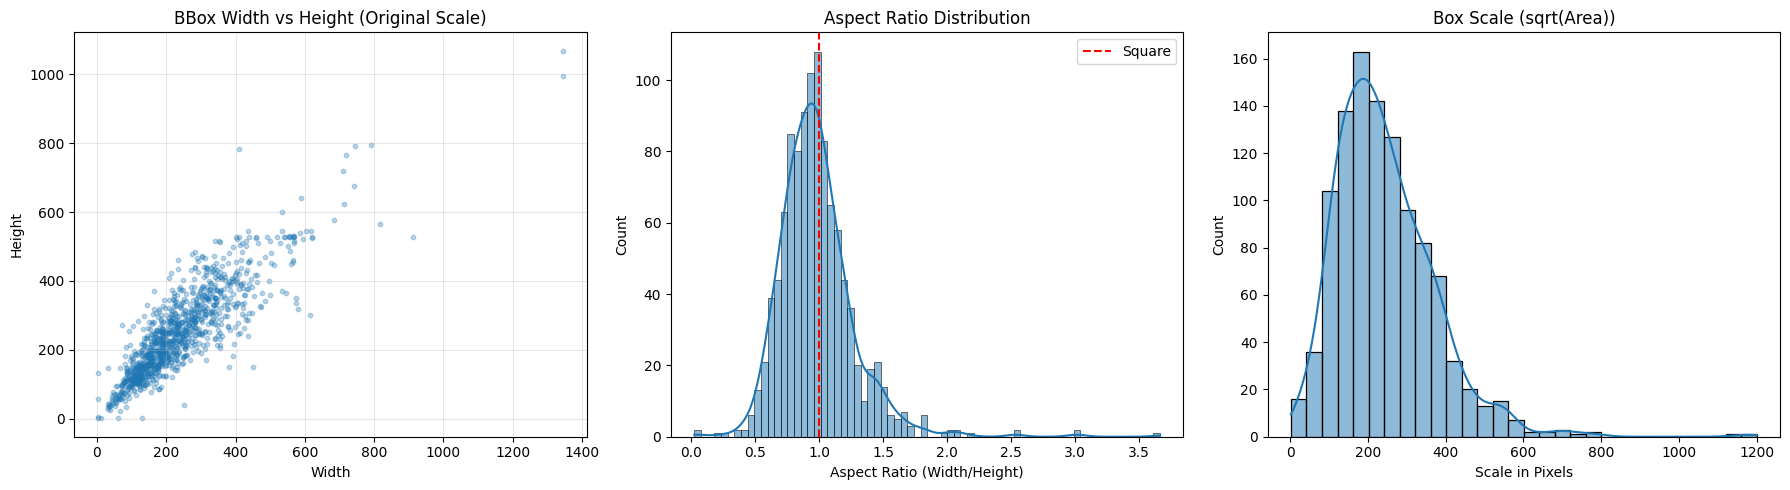

In [10]:
def visualize_box_stats(labels_df, target_size=512):
    # 1. Scale boxes to the training size (512x512)
    # Calculate dimensions
    widths = labels_df['xmax'] - labels_df['xmin']
    heights = labels_df['ymax'] - labels_df['ymin']

    aspect_ratios = widths / heights
    areas = widths * heights

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    print(aspect_ratios[aspect_ratios >= 2])

    # Plot 1: Width vs Height
    axes[0].scatter(widths, heights, alpha=0.3, s=10)
    axes[0].set_title("BBox Width vs Height (Original Scale)")
    axes[0].set_xlabel("Width")
    axes[0].set_ylabel("Height")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Aspect Ratios
    sns.histplot(aspect_ratios[aspect_ratios <=5], bins=70, ax=axes[1], kde=True) # <=5 is used to ignore two outliers
    axes[1].axvline(1.0, color='r', linestyle='--', label="Square")
    axes[1].set_title("Aspect Ratio Distribution")
    axes[1].set_xlabel("Aspect Ratio (Width/Height)")
    axes[1].legend()

    # Plot 3: Box Area (Scale)
    sns.histplot(np.sqrt(areas), bins=30, ax=axes[2], kde=True)
    axes[2].set_title("Box Scale (sqrt(Area))")
    axes[2].set_xlabel("Scale in Pixels")

    plt.tight_layout()
    plt.show()

visualize_box_stats(dataset_fasterrcnn.labels_df)

**Train-Test-Val Split and Preprocessing**

---



In [11]:
train_tfms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.CLAHE(clip_limit=(2.0, 4.0), tile_grid_size=(8, 8), p=0.3), # CLAHE data augmentation (already in Albumentation)
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(p=0.2),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"])
)

In [12]:
# --- FASTER RCNN ---
from torch.utils.data import Subset
import torch

def make_splits_fasterrcnn(PATH_IMAGES, PATH_LABELS, img_size=512, default_class=0,
                           train_tfms=None, seed=42, train_ratio=0.6, val_ratio=0.3):
    # dataset per train (con augmentations)
    dataset_train_aug = KvasirPolypDataset(
      images_dir=PATH_IMAGES,
      labels_dir=PATH_LABELS,
      img_size=img_size,
      default_class=default_class,
      format="fasterrcnn",
      transforms=train_tfms
    )

    # dataset per val/test (senza augmentations)
    dataset_eval = KvasirPolypDataset(
      images_dir=PATH_IMAGES,
      labels_dir=PATH_LABELS,
      img_size=img_size,
      default_class=default_class,
      format="fasterrcnn",
      transforms=None
    )

    N = len(dataset_eval)
    g = torch.Generator().manual_seed(seed)
    perm = torch.randperm(N, generator=g).tolist()

    train_size = int(train_ratio * N)
    val_size   = int(val_ratio * N)
    test_size  = N - train_size - val_size

    train_idx = perm[:train_size]
    val_idx   = perm[train_size:train_size + val_size]
    test_idx  = perm[train_size + val_size:]

    train_ds = Subset(dataset_train_aug, train_idx)
    val_ds   = Subset(dataset_eval, val_idx)
    test_ds  = Subset(dataset_eval, test_idx)

    return train_ds, val_ds, test_ds

train_dataset_fasterrcnn, val_dataset_fasterrcnn, test_dataset_fasterrcnn = make_splits_fasterrcnn(
    PATH_IMAGES=PATH_IMAGES,
    PATH_LABELS=PATH_LABELS,
    img_size=512,
    default_class=0,
    train_tfms=train_tfms,   # only for training
    seed=42
)


# --- YOLO ---

# Define the split ratios
train_size = int(0.6 * len(dataset_yolo))  # 60% of the data for training
val_size = int(0.3 * len(dataset_yolo))  # Remaining 20% for testing
test_size = len(dataset_yolo)-train_size-val_size  # Remaining samples for validation

# Split the dataset. Use the function random_split with the obtained sizes
train_dataset_yolo, test_dataset_yolo = random_split(dataset_yolo, [train_size, val_size + test_size])
val_dataset_yolo, test_dataset_yolo = random_split(test_dataset_yolo, [val_size, test_size])


Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0
Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0


Cluster Strategy:
Validation (Avg Best IoU):
  Default Anchors: 0.6808
  K-Means Anchors: 0.7776 (Higher is better!)


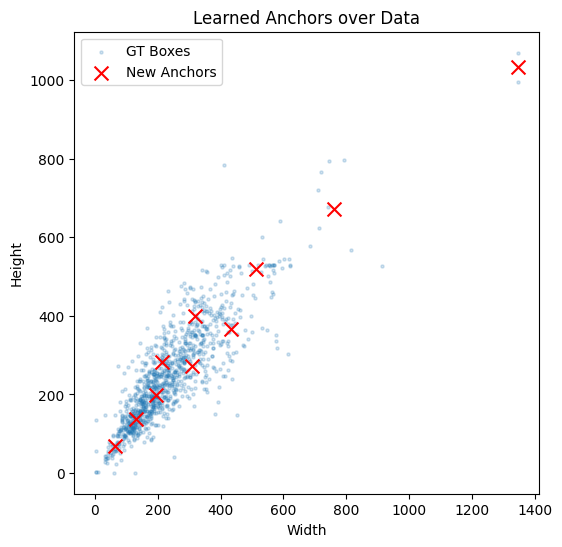


Suggested Anchor Sizes (w, h):
 [[ 195.04090909  198.74090909]
 [ 310.18115942  273.02898551]
 [ 511.94        519.78      ]
 [  65.4556962    70.02531646]
 [ 131.46956522  138.25217391]
 [1346.         1032.        ]
 [ 317.90350877  398.5877193 ]
 [ 759.22222222  671.33333333]
 [ 431.62666667  365.61333333]
 [ 212.50649351  282.58441558]]
Quantile Strategy:
Validation (Avg Best IoU):
  Default Anchors : 0.6808
  Quantile Anchors: 0.7823


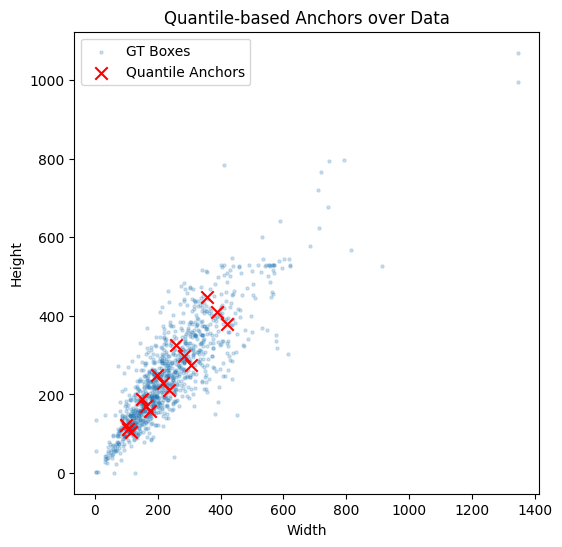


Suggested Anchor Sizes (w, h):
 [[ 97.62736607 122.79343879]
 [106.83941627 112.20577965]
 [115.33603637 103.93976052]
 [149.34935173 187.84815384]
 [163.44185244 171.65126056]
 [176.43989545 159.00598857]
 [198.41739936 249.56480712]
 [217.13992684 228.0464985 ]
 [234.40841753 211.24668014]
 [258.91875154 325.66200593]
 [283.35014443 297.58234346]
 [305.88413624 275.65993136]
 [356.09422815 447.88706863]
 [389.69503126 409.26875429]
 [420.68631472 379.11858413]]


In [19]:
from sklearn.cluster import KMeans


def get_kmeans_anchors(train_labels, val_labels, img_size=512, n_clusters=5):
    """
    Runs K-Means on the box dimensions normalized to the training image size.
    """
    # 1. Prepare data scaled to 512x512
    # We estimate scaling. For exact precision, we'd need original image dimensions.
    # Here we assume the input boxes are from the original images.
    # If your dataset resizes by preserving aspect ratio, this approximation is decent.

    # Gather all widths and heights
    box_wh = []

    # We assume 'labels_df' has columns: xmin, ymin, xmax, ymax
    # And we assume the images are roughly square or resized to square 512x512
    # NOTE: In a perfect world, you'd loop through your Dataset to get exact resized boxes.
    # Here is a vectorized approx:

    train_ws = train_labels['xmax'] - train_labels['xmin']
    train_hs = train_labels['ymax'] - train_labels['ymin']
    val_ws = val_labels['xmax'] - val_labels['xmin']
    val_hs = val_labels['ymax'] - val_labels['ymin']

    # Simplification: Assume average original image is ~512-1000px,
    # but let's normalize to [0,1] first then scale to 512
    # Since we don't have image_w/h in df, we can just cluster on raw values
    # and then scale the *centroids* to 512 later if we knew the average scale.

    # BETTER APPROACH: Cluster on the Aspect Ratios and Sqrt(Area) directly
    train_X = np.column_stack((train_ws, train_hs))
    val_X = np.column_stack((val_ws, val_hs))

    # 2. Run K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(train_X)
    centers = kmeans.cluster_centers_

    # 3. Validation: Calculate Mean IoU of the closest anchor for each box
    def iou_wh(box_wh, anchors_wh):
        # returns max IoU for each box against any of the anchors
        # box_wh: (N, 2), anchors_wh: (K, 2)
        intersection_w = np.minimum(box_wh[:, None, 0], anchors_wh[None, :, 0])
        intersection_h = np.minimum(box_wh[:, None, 1], anchors_wh[None, :, 1])
        intersection = intersection_w * intersection_h

        box_area = box_wh[:, 0] * box_wh[:, 1]
        anchor_area = anchors_wh[:, 0] * anchors_wh[:, 1]
        union = box_area[:, None] + anchor_area[None, :] - intersection
        return (intersection / union).max(axis=1).mean()

    # Compare against Default COCO Anchors (roughly 32^2 to 512^2, ratios 0.5, 1, 2)
    # We simplify defaults to just a set of representative shapes
    defaults = np.array([[32,32], [64,64], [128,128], [256,256], [512,512],
                         [128, 64], [64, 128]]) # Simplified list of defaults

    avg_iou_custom = iou_wh(val_X, centers)
    avg_iou_default = iou_wh(val_X, defaults)

    print(f"Validation (Avg Best IoU):")
    print(f"  Default Anchors: {avg_iou_default:.4f}")
    print(f"  K-Means Anchors: {avg_iou_custom:.4f} (Higher is better!)")

    # 4. Plot to validate visually
    plt.figure(figsize=(6, 6))
    plt.scatter(val_ws, val_hs, alpha=0.2, s=5, label='GT Boxes')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='x', label='New Anchors')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.legend()
    plt.title("Learned Anchors over Data")
    plt.show()

    return centers

def get_quantile_anchors(
    train_labels,
    val_labels,
    scale_quantiles=(0.1, 0.3, 0.5, 0.7, 0.9),
    ratio_quantiles=(0.25, 0.5, 0.75),
):
    """
    Generates anchors using quantiles of scale and aspect ratio distributions.

    Args:
        labels_df: DataFrame with columns xmin, ymin, xmax, ymax
        scale_quantiles: quantiles for sqrt(area)
        ratio_quantiles: quantiles for aspect ratio (w / h)

    Returns:
        anchors_wh: (K, 2) array of (w, h)
    """

    # ------------------------------------------------------------
    # 1. Extract box geometry
    # ------------------------------------------------------------
    train_ws = train_labels['xmax'].values - train_labels['xmin'].values
    train_hs = train_labels['ymax'].values - train_labels['ymin'].values
    val_ws = train_labels['xmax'].values - train_labels['xmin'].values
    val_hs = train_labels['ymax'].values - train_labels['ymin'].values

    # Safety: avoid degenerate boxes
    eps = 1e-6
    train_ws = np.clip(train_ws, eps, None)
    train_hs = np.clip(train_hs, eps, None)
    val_ws = np.clip(val_ws, eps, None)
    val_hs = np.clip(val_hs, eps, None)

    # ------------------------------------------------------------
    # 2. Work in (scale, ratio) space
    # ------------------------------------------------------------
    train_scales = np.sqrt(train_ws * train_hs)     # object size
    train_ratios = train_ws / train_hs              # aspect ratio
    val_scales = np.sqrt(val_ws * val_hs)     # object size
    val_ratios = val_ws / val_hs              # aspect ratio

    # ------------------------------------------------------------
    # 3. Quantile selection (distribution-aware anchors)
    # ------------------------------------------------------------
    scale_vals = np.quantile(train_scales, scale_quantiles)
    ratio_vals = np.quantile(train_ratios, ratio_quantiles)

    # ------------------------------------------------------------
    # 4. Build anchors via Cartesian product
    #    scale = sqrt(w * h), ratio = w / h
    # ------------------------------------------------------------
    anchors = []
    for s in scale_vals:
        for r in ratio_vals:
            w = s * np.sqrt(r)
            h = s / np.sqrt(r)
            anchors.append([w, h])

    anchors = np.array(anchors)

    # ------------------------------------------------------------
    # 5. Validation: Mean best IoU (same as your code)
    # ------------------------------------------------------------
    def iou_wh(box_wh, anchors_wh):
        intersection_w = np.minimum(box_wh[:, None, 0], anchors_wh[None, :, 0])
        intersection_h = np.minimum(box_wh[:, None, 1], anchors_wh[None, :, 1])
        intersection = intersection_w * intersection_h

        box_area = box_wh[:, 0] * box_wh[:, 1]
        anchor_area = anchors_wh[:, 0] * anchors_wh[:, 1]
        union = box_area[:, None] + anchor_area[None, :] - intersection
        return (intersection / union).max(axis=1).mean()

    X = np.column_stack((val_ws, val_hs))

    defaults = np.array([
        [32, 32], [64, 64], [128, 128], [256, 256], [512, 512],
        [128, 64], [64, 128]
    ])

    avg_iou_custom = iou_wh(X, anchors)
    avg_iou_default = iou_wh(X, defaults)

    print("Validation (Avg Best IoU):")
    print(f"  Default Anchors : {avg_iou_default:.4f}")
    print(f"  Quantile Anchors: {avg_iou_custom:.4f}")

    # ------------------------------------------------------------
    # 6. Visualization
    # ------------------------------------------------------------
    plt.figure(figsize=(6, 6))
    plt.scatter(val_ws, val_hs, alpha=0.2, s=5, label='GT Boxes')
    plt.scatter(anchors[:, 0], anchors[:, 1],
                c='red', s=80, marker='x', label='Quantile Anchors')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.legend()
    plt.title("Quantile-based Anchors over Data")
    plt.show()

    return anchors

print("Cluster Strategy:")
cluster_centers = get_kmeans_anchors(train_dataset_fasterrcnn.dataset.labels_df, val_dataset_fasterrcnn.dataset.labels_df, n_clusters=10)
print("\nSuggested Anchor Sizes (w, h):\n", cluster_centers)

print("Quantile Strategy:")
quantile_centers = get_quantile_anchors(train_dataset_fasterrcnn.dataset.labels_df, val_dataset_fasterrcnn.dataset.labels_df)
print("\nSuggested Anchor Sizes (w, h):\n", quantile_centers)

# Batch Data Loaders

In order to load the images in batches, we define batch generating functions. Again one for YOLO format and one for Faster RCNN format.
For yolo, we have to implement the batch generating function by ourselves:

In [20]:
def collate_fn_fasterrcnn(batch):
    return tuple(zip(*batch))

def collate_fn_yolo(batch):
    """
    Custom collate function for YOLO-format batches.

    Takes a list of (image, targets, img_id) tuples and combines them into:
        - images: stacked tensor of shape (B, 3, H, W)
        - all_targets: concatenated tensor of shape (M, 6) where each row is
          [batch_index, class, x_center, y_center, width, height]
        - img_ids: list of image identifiers
    """
    images = []
    all_targets = []
    img_ids = []

    for i, (img, targets, img_id) in enumerate(batch):
        images.append(img)
        img_ids.append(img_id)

        if targets.numel() > 0:
            # add column with the index of the image in the batch
            batch_idx = torch.full(
                (targets.size(0), 1),
                i,
                dtype=targets.dtype
            )
            # [batch_idx, class, x_c, y_c, w, h]
            t = torch.cat([batch_idx, targets], dim=1)
            all_targets.append(t)

    images = torch.stack(images, dim=0)  # (B,3,H,W)

    if len(all_targets) > 0:
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_targets = torch.zeros((0, 6), dtype=torch.float32)

    return images, all_targets, img_ids

In [21]:
train_dataloader_fasterrcnn = DataLoader(
    train_dataset_fasterrcnn,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

val_dataloader_fasterrcnn = DataLoader(
    val_dataset_fasterrcnn,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

test_dataloader_fasterrcnn = DataLoader(
    test_dataset_fasterrcnn,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

train_dataloader_yolo = DataLoader(
    train_dataset_yolo,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

val_dataloader_yolo = DataLoader(
    val_dataset_yolo,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

test_data_loader_yolo = DataLoader(
    test_dataset_yolo,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

# try to iterate one batch
for images, targets, img_ids in train_dataloader_yolo:
    print("Batch images shape:", images.shape)  # (B,3,H,W)
    print("Targets shape:", targets.shape)      # (M,6) -> [batch_idx, class, x_c, y_c, w, h]
    print("Example img_ids:", img_ids[:3])
    break

Batch images shape: torch.Size([1, 3, 512, 512])
Targets shape: torch.Size([1, 6])
Example img_ids: ['cju3x5u2tiihx0818914gzxy1']


## Utils For Training

In [22]:
def freeze_backbone(model):
    for param in model.backbone.parameters():
        param.requires_grad = False


def freeze_backbone_until_layer1(model):
    # freeze everything first
    for param in model.backbone.parameters():
        param.requires_grad = False

    # unfreeze layer2, layer3, layer4
    for name, param in model.backbone.body.named_parameters():
        if name.startswith("layer2") or name.startswith("layer3") or name.startswith("layer4"):
            param.requires_grad = True


In [23]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, history, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'history': history # Save the history list
    }
    torch.save(checkpoint, path)

In [24]:
def load_checkpoint(path, model, optimizer=None, scheduler=None, device="cuda"):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    start_epoch = checkpoint["epoch"] + 1
    train_losses = checkpoint.get("train_losses", [])
    val_losses = checkpoint.get("val_losses", [])
    history = checkpoint.get("history", []) # Load the history list

    return start_epoch, train_losses, val_losses, history

## 1) Faster RCNN with frozen backbone

### Training

In [ ]:
model = fasterrcnn_resnet50_fpn(
    weights="DEFAULT"
)

# replace classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    2               # 0 background, 1 polyp
)

# freeze backbone
# freeze_backbone(model)

# freeze only stem + layer1 of backbone
freeze_backbone_until_layer1(model)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.0015,  # lower as we train deeper
    momentum=0.9,
    weight_decay=5e-4
)

# scheduler based on val-loss
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=3
)

In [ ]:
RESUME_TRAINING = True

if RESUME_TRAINING:
  checkpoint_path = "/content/drive/MyDrive/checkpoints/fasterrcnn_epoch_15.pth"

  val_losses = []
  history = [] # Ensure history is initialized

  if os.path.exists(checkpoint_path):
      print(f"Checkpoint found: {checkpoint_path}")
      start_epoch, train_losses, val_losses, history = load_checkpoint(
          checkpoint_path,
          model,
          optimizer,
          lr_scheduler,
          device=device
      )
  else:
      print("Checkpoint not found, starting training from the beginning")

else:
  start_epoch = 0
  train_losses = []
  val_losses = []
  history = []

num_epochs = 15

for epoch in range(start_epoch, num_epochs):
    model.train()
    # After calling model.train(), explicitly set the backbone to eval mode to freeze BatchNorm running statistics
    for m in model.backbone.modules():
      if isinstance(m, torch.nn.BatchNorm2d): # # Freeze BatchNorm running statistics in the backbone to ensure stable training with batch_size = 1
          m.eval()

    epoch_loss = 0.0
    n_batches = 0

    for images, targets, _ in train_dataloader_fasterrcnn:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        n_batches += 1

    avg_epoch_loss = epoch_loss / n_batches
    train_losses.append(avg_epoch_loss)

    val_results = evaluate_model_with_metrics(
        model,
        val_dataloader_fasterrcnn,
        device,
        iou_match_thr=0.3,
        save_outputs=False
    )

    val_losses.append(val_results["val_loss"])
    history.append(val_results) # Append validation results to history

    lr_scheduler.step(val_results["val_loss"])

    save_checkpoint(
        model,
        optimizer,
        lr_scheduler,
        epoch,
        train_losses,
        val_losses,
        history, # Pass history to save_checkpoint
        f"/content/drive/MyDrive/checkpoints/fasterrcnn_epoch_{epoch+1}.pth"
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {avg_epoch_loss:.4f} | "
        f"Val Loss: {val_losses[-1]:.4f} | "
        f"mAP: {val_results['mAP']*100:.2f}%"
    )

Checkpoint found: /content/drive/MyDrive/checkpoints/fasterrcnn_epoch_15.pth


## Loading Trained Model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DL Medical Imaging/Project/checkpoints/niklas_02_01_26/fasterrcnn_epoch_15.pth"

if not os.path.exists(checkpoint_path):
    print("Checkpoint not found, cannot load losses for plotting.")

else:
    print(f"Checkpoint found: {checkpoint_path}")

    # additional check
    checkpoint = torch.load(checkpoint_path, map_location='cpu') # Load to CPU to avoid device issues
    print("Keys in the loaded checkpoint:")
    for key in checkpoint.keys():
        print(f"- {key}")

    start_epoch, train_losses, val_losses, history = load_checkpoint(
        checkpoint_path,
        model,
        optimizer,
        lr_scheduler,
        device=device
    )

    print(f"Lengths after loading checkpoint: train_losses={len(train_losses)}, val_losses={len(val_losses)}, history={len(history)}")

NameError: name 'os' is not defined

## Evaluation

Visualize the loss in training through the 20 epochs.

Validation Loop

In [ ]:
def evaluate_model_with_metrics(model, dataloader, device, iou_match_thr = 0.3,save_outputs = False):

    """
    Evaluates Faster R-CNN model and computes mAP, accuracy, and IoU.

    Args:
        model : The object detection model.
        dataloader : Dataloader for the validation/test dataset.
        device : Device to run the evaluation
        iou_match_thr: IoU threshold to consider a prediction matched to a GT
        save_outputs: if True, returns also all_outputs (list) with predictions + img_ids

    Returns:
        dict: Dictionary containing mAP, accuracy, and Jaccard Index (IoU).
    """

    model.to(device)
    metric = MeanAveragePrecision()

    total_correct = 0
    total_predictions = 0
    total_iou = 0.0
    all_outputs = []

    val_loss = 0
    n_batches = 0

    # Store original model training state to restore it later
    original_model_training_state = model.training

    model.eval() # Set model to evaluation mode for overall loop
    with torch.no_grad():
        for images, targets,img_ids in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # --- VALIDATION LOSS CALCULATION ---
            # For Faster R-CNN models, losses are computed when the model is in training mode.
            # Temporarily set to train mode to get the loss_dict.
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            n_batches += 1
            model.eval() # Switch back to eval mode for predictions

            # Get model predictions for images
            outputs = model(images)

            # Create list with predictions on cpu
            preds = []
            for output in outputs:
                preds.append({
                    "boxes": output['boxes'].cpu(),
                    "scores": output["scores"].cpu(),
                    "labels": output['labels'].cpu(),
                })

            # Create list with GT on cpu
            gt = []
            for target in targets:
                gt.append({
                    "boxes": target['boxes'].detach().cpu(),
                    "labels": target["labels"].detach().cpu(),
                })

            metric.update(preds, gt)

            # Calculate accuracy and IoU
            for pred, truth in zip(outputs, targets):
                pred_boxes = pred["boxes"]
                pred_labels = pred["labels"]
                gt_boxes = truth["boxes"]
                gt_labels = truth["labels"]

                if len(gt_boxes) > 0 and len(pred_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)
                    max_ious, max_indices = ious.max(dim=1)

                    # Count IoU values above threshold
                    matched = max_ious > iou_match_thr

                    if matched.any():
                        total_correct += (pred_labels[matched] == gt_labels[max_indices[matched]]).sum().item()
                        total_predictions += matched.sum().item()
                        total_iou += max_ious[matched].sum().item()

            if save_outputs:
              for out,img_id in zip(outputs,img_ids):
                all_outputs.append({
                    'img_id': img_id,
                    'boxes': out['boxes'].detach().cpu(),
                    'labels': out['labels'].detach().cpu(),
                    'scores': out['scores'].detach().cpu(),
                })

    avg_val_loss = val_loss / n_batches if n_batches > 0 else 0.0

    # Restore the model's original training state
    model.train(original_model_training_state)

    # Compute final metrics
    results = metric.compute() # mAP metric
    accuracy = total_correct / total_predictions if total_predictions > 0 else 0.0
    mean_iou = total_iou / total_predictions if total_predictions > 0 else 0.0

    final_results = {
        "val_loss": avg_val_loss,
        "mAP": results["map"].item(),
        "mAP_50": results["map_50"].item() if "map_50" in results else None,
        "mAP_75": results["map_75"].item() if "map_75" in results else None,
        "Accuracy_matched": accuracy,
        "IoU_matched": mean_iou,
        "Matched_count": total_predictions,
    }
    if save_outputs:
        return final_results, all_outputs
    else:
        return final_results

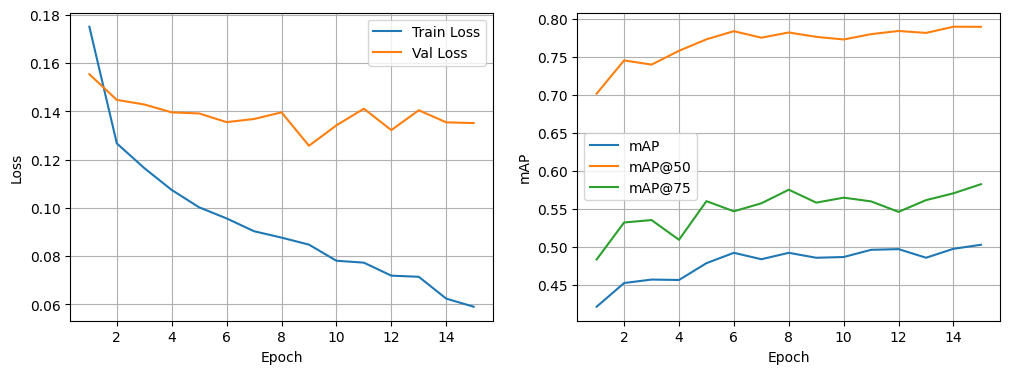

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, [h["mAP"] for h in history], label="mAP")
plt.plot(epochs, [h["mAP_50"] for h in history], label="mAP@50")
plt.plot(epochs, [h["mAP_75"] for h in history], label="mAP@75")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)



plt.show()

In [ ]:
def evaluate_model_with_metrics_conf(model, dataloader, device, confidence_threshold=0.6):
    """
    Evaluates a Faster R-CNN model and computes mAP, accuracy, and Jaccard Index (IoU)
    considering the confidence threshold.

    Args:
        model (torch.nn.Module): The object detection model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the test dataset.
        device (torch.device): Device to run the evaluation (e.g., 'cuda' or 'cpu').
        confidence_threshold (float): Minimum confidence score for a prediction to be considered.

    Returns:
        dict: Dictionary containing mAP, accuracy, and Jaccard Index (IoU).
    """
    model.to(device)  # Move model to selected device
    model.eval()  # Set the model to evaluation mode
    metric = MeanAveragePrecision() # call the object mAP from torchmetrics

    total_correct = 0
    total_predictions = 0
    total_iou = 0.0

    with torch.no_grad():
        for images, targets,_ in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            outputs = model(images)


            # First, filter predictions based on confidence threshold
            preds = []
            for output in outputs:
                high_confidence_preds = output["scores"] >= confidence_threshold
                preds.append({
                    "boxes": output['boxes'][high_confidence_preds].cpu(),
                    "scores": output["scores"][high_confidence_preds].cpu(),
                    "labels": output['labels'][high_confidence_preds].cpu(),
                })

            # Create list with gt on cpu
            gt = []
            for target in targets:
                gt.append({
                    "boxes": target["boxes"].cpu(),
                    "labels": target["labels"].cpu(),
                })

            # Update mAP metric
            metric.update(preds,gt)

            # Calculate accuracy and IoU
            for pred, truth in zip(preds, targets):
                pred_boxes = pred["boxes"].to(device)
                pred_labels = pred["labels"].to(device)
                gt_boxes = truth["boxes"].to(device)
                gt_labels = truth["labels"]

                if len(gt_boxes) > 0 and len(pred_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)  # IoU between predicted and ground truth boxes
                    max_ious, max_indices = ious.max(dim=1)

                    # Count IoU values above threshold (e.g., IoU > 0.3)
                    matched =  max_ious > 0.5 # indices of matched bboxs
                    total_correct += (pred_labels[matched] == gt_labels[max_indices[matched]]).sum().item()
                    total_predictions += matched.sum().item()

                    # Aggregate IoU
                    total_iou += max_ious[matched].sum().item()

    # Compute final metrics
    results = metric.compute()
    accuracy = total_correct / total_predictions if total_predictions > 0 else 0.0
    mean_iou = total_iou / total_predictions if total_predictions > 0 else 0.0

    # Combine all metrics in a single dictionary
    final_results = {
        "mAP": results["map"],  # Mean Average Precision
        "Accuracy": accuracy,   # Accuracy of label predictions
        "IoU": mean_iou,  # Average IoU for matched boxes
    }
    return final_results

In [ ]:
results = evaluate_model_with_metrics_conf(model, val_dataloader_fasterrcnn, device, 0.8)
print("\nEvaluation Metrics:")
print("="*30)
print(f"{'Mean Average Precision (mAP)':<30}: {results['mAP']*100:.2f}%")
print(f"{'Accuracy':<30}: {results['Accuracy']*100:.2f}%")
print(f"{'Mean IoU (Jaccard Index)':<30}: {results['IoU']*100:.2f}%")
print("="*30)

Evaluating: 100%|██████████| 300/300 [00:29<00:00, 10.16it/s]



Evaluation Metrics:
Mean Average Precision (mAP)  : 64.19%
Accuracy                      : 100.00%
Mean IoU (Jaccard Index)      : 87.47%


metrics across different values of confidence treshold

In [ ]:
def evaluate_with_confidence_range(model, dataloader, device, confidence_range):
    """
    Evaluates the model with different confidence thresholds and plots mAP, Accuracy, and IoU.

    Args:
        model (torch.nn.Module): The object detection model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the test dataset.
        device (torch.device): Device to run the evaluation (e.g., 'cuda' or 'cpu').
        confidence_range (numpy.ndarray): Range of confidence thresholds to evaluate.
        iou_threshold (float): IoU threshold for considering a prediction as a true positive.

    Returns:
        None: Plots the metrics as a function of confidence threshold.
    """
    # Store metrics for plotting
    mAP_values = []
    accuracy_values = []
    iou_values = []

    for confidence_threshold in confidence_range:
        # Call the evaluation function for each confidence threshold
        results = evaluate_model_with_metrics_conf(model, dataloader, device, confidence_threshold)

        # Append the results
        mAP_values.append(results["mAP"])
        accuracy_values.append(results["Accuracy"])
        iou_values.append(results["IoU"])

    # Convert to numpy arrays for easy plotting
    mAP_values = np.array(mAP_values)
    accuracy_values = np.array(accuracy_values)
    iou_values = np.array(iou_values)

    # Plot the metrics as a function of confidence threshold
    plt.figure(figsize=(12, 6))

    # Plot mAP
    plt.subplot(1, 3, 1)
    plt.plot(mAP_values)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('mAP')
    plt.title('mAP vs Confidence Threshold')
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(accuracy_values)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Confidence Threshold')
    plt.grid(True)

    # Plot IoU
    plt.subplot(1, 3, 3)
    plt.plot(iou_values)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('IoU')
    plt.title('IoU vs Confidence Threshold')
    plt.grid(True)

    # Show all plots
    plt.tight_layout()
    plt.show()


Evaluating: 100%|██████████| 300/300 [00:29<00:00, 10.19it/s]


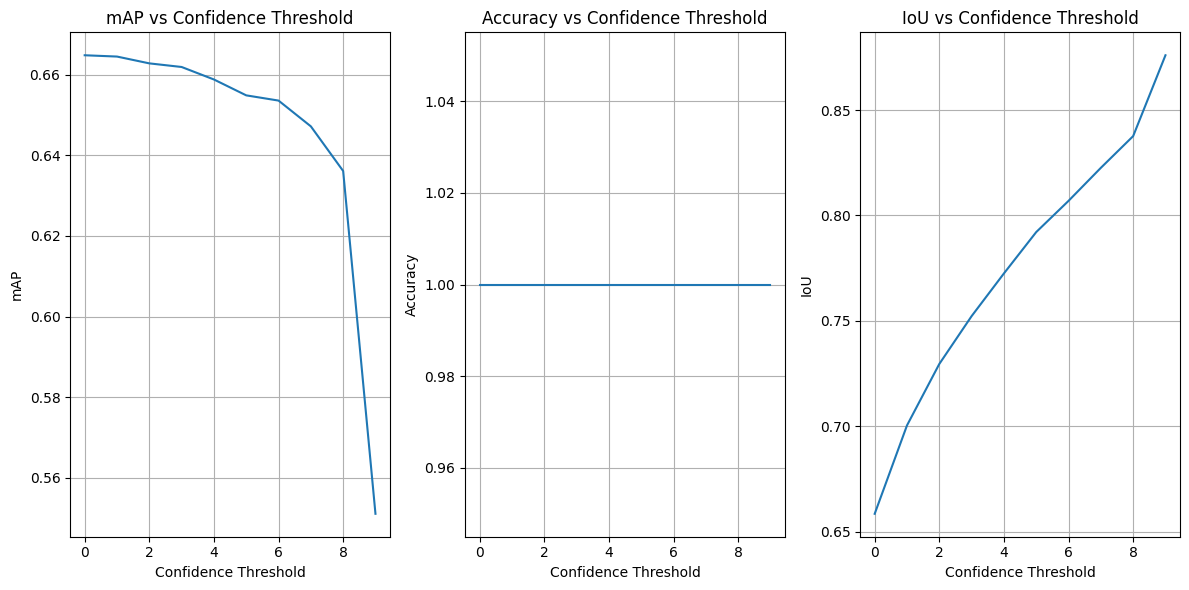

In [ ]:
# Define the range of confidence thresholds you want to evaluate
confidence_range = np.linspace(0.1, 0.95, 10)

# Call the evaluation and plotting function evaluate_with_confidence_range
evaluate_with_confidence_range(model, val_dataloader_fasterrcnn, device, confidence_range)

## Qualitative

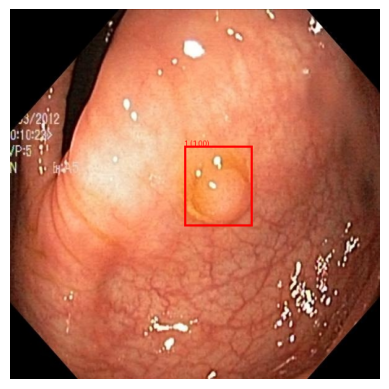

In [ ]:
# Visualization
def visualize_predictions(image, predictions, confidence_threshold):
    """
    Visualizes bounding boxes with high confidence, assigning unique colors to each label.

    Args:
        image (PIL.Image.Image): The input image.
        predictions (dict): Model predictions containing 'boxes', 'labels', and 'scores'.
        confidence_threshold (float): Minimum score to visualize a prediction.
    """
    # Extract bounding boxes, labels, and scores from predictions
    boxes = predictions['boxes']  # List of predicted bounding boxes (each box is a tensor of [xmin, ymin, xmax, ymax])
    labels = predictions['labels']  # List of predicted class labels
    scores = predictions['scores']  # List of predicted confidence scores for each bounding box

    # Filter predictions based on confidence threshold
    high_conf_indices = torch.where(scores >= confidence_threshold)[0] # create a list with indices of scores that are higher than the confidence_threshold
    boxes = [boxes[i].tolist() for i in high_conf_indices] # create a list of lists with the boxes corresponding to the high_conf_indices
    labels = [labels[i].item() for i in high_conf_indices] # create a list of the labels corresponding to the high_conf_indices
    scores = [scores[i].item() for i in high_conf_indices] # create a list of the scores corresponding to the high_conf_indices

    # Draw the bounding boxes on the image
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)
    for box, label, score in zip(boxes, labels, scores):
        color = 'red' # select the color of the class
        draw.rectangle(box, outline=color, width=3) # plot the box
        draw.text((box[0], max(0, box[1] - 10)), f"{label} ({score:.2f})", fill=color) # plot text

    return image_draw
# Test on an example
# Obtain the next batch from test_loader using 'next' and 'iter'
batch_images, batch_targets, batch_img_ids = next(iter(val_dataloader_fasterrcnn))
image_to_visualize = batch_images[0] # Take the first image from the batch

# Evaluate on an image.
# Set the model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()
with torch.no_grad():
    image = batch_images[0].to(device)  # Fetch a batch image from the dataset
    prediction = model([image])

    # Convert image tensor to PIL Image
    pil_image = F.to_pil_image(batch_images[0])

    confidence_threshold = 0.6

    high_conf_image = visualize_predictions(pil_image, prediction[0], confidence_threshold)
    # Show the image
    plt.imshow(high_conf_image)
    plt.axis("off")
    plt.show()